## <center> Covid Vaccination Prediction <center> 

Importing required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

Reading the covid dataset provided in https://github.com/owid/covid-19-data/tree/master/public/data.

In [2]:
data = pd.read_csv('owid-covid-data.csv')
data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85166,ZWE,Africa,Zimbabwe,2021-04-26,38102.0,16.0,34.714,1560.0,3.0,1.000,2563.560,1.077,2.336,104.959,0.202,0.067,1.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1495.0,484446.0,32.594,0.101,1722.0,0.116,0.020,49.6,tests performed,411610.0,353834.0,57776.0,21592.0,13517.0,2.77,2.38,0.39,909.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
85167,ZWE,Africa,Zimbabwe,2021-04-27,38164.0,62.0,41.286,1565.0,5.0,1.571,2567.731,4.171,2.778,105.296,0.336,0.106,1.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2355.0,486801.0,32.753,0.158,1703.0,0.115,0.024,41.2,tests performed,433939.0,370676.0,63263.0,22329.0,15562.0,2.92,2.49,0.43,1047.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
85168,ZWE,Africa,Zimbabwe,2021-04-28,38191.0,27.0,30.143,1565.0,0.0,1.429,2569.548,1.817,2.028,105.296,0.000,0.096,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025.0,488826.0,32.889,0.136,1716.0,0.115,0.018,56.9,tests performed,458013.0,388021.0,69992.0,24074.0,17860.0,3.08,2.61,0.47,1202.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49

Information of dataset. Even it has 85171 examples, since the project aims to predict people_fully_vaccinated_per_hundred, we won't use most of the data. 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85171 entries, 0 to 85170
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               85171 non-null  object 
 1   continent                              81060 non-null  object 
 2   location                               85171 non-null  object 
 3   date                                   85171 non-null  object 
 4   total_cases                            83072 non-null  float64
 5   new_cases                              83070 non-null  float64
 6   new_cases_smoothed                     82069 non-null  float64
 7   total_deaths                           73408 non-null  float64
 8   new_deaths                             73566 non-null  float64
 9   new_deaths_smoothed                    82069 non-null  float64
 10  total_cases_per_million                82623 non-null  float64
 11  ne

Data has so many inconsistent features.

In [4]:
data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
count,8.307200e+04,83070.000000,82069.00000,7.340800e+04,73566.000000,82069.000000,82623.000000,82621.000000,81625.000000,72972.000000,73130.000000,81625.000000,68942.000000,8684.000000,8684.000000,10814.000000,10814.000000,789.000000,789.000000,1295.000000,1295.000000,3.894500e+04,3.865200e+04,38652.000000,38945.000000,4.462500e+04,44625.000000,42904.000000,42311.000000,9.374000e+03,8.744000e+03,6.431000e+03,7.954000e+03,1.509200e+04,9374.000000,8744.000000,6431.000000,15092.000000,72207.000000,8.462200e+04,79274.000000,76706.000000,75830.000000,76276.000000,77046.000000,52449.000000,77634.000000,78779.000000,60828.000000,59931.000000,39007.000000,70847.000000,80833.000000,77517.000000
mean,8.250083e+05,5808.325352,5780.94148,2.300409e+04,139.052606,122.992577,10062.094271,74.337193,74.307323,224.882585,1.507874,1.335129,1.019094,1087.808268,26.410840,4832.767339,173.771940,280.673146,21.121653,3981.037431,115.517820,4.401999e+04,5.963484e+06,227.476052,1.937240,4.141631e+04,1.775553,0.088971,159.455343,1.448260e+07,8.974136e+06,4.618760e+06,4.223566e+05,2.214247e+05,13.339040,9.359133,5.087038,2774.854360,58.740033,1.284213e+08,349.043245,30.522465,8.773478,5.557222,19138.882312,13.348729,257.783338,7.820936,10.520272,32.656970,50.916220,3.029584,73.165416,0.727123
std,5.705959e+06,36285.123205,35533.79070,1.360297e+05,758.882229,693.391638,19295.833152,175.740570,149.026786,394.722350,3.979279,2.936500,0.356793,3036.371200,27.869382,12440.913787,216.378928,588.426814,37.119393,11632.511679,230.474544,2.280829e+05,2.702657e+07,495.353769,15.289039,1.484500e+05,4.810457,0.097594,864.928764,6.637651e+07,3.793750e+07,1.819767e+07,1.691168e+06,1.133430e+06,21.682342,13.808968,9.639009,4635.192312,21.663223,6.904393e+08,1699.215916,9.114990,6.224095,4.248993,19821.321091,19.942984,118.765619,3.977056,10.402965,13.475297,31.763233,2.463559,7.549526,0.150057
min,1.000000e+00,-74347.000000,-6223.00000,1.000000e+00,-1918.000000,-232.143000,0.001000,-2153.437000,-276.825000,0.001000,-76.445000,-10.921000,-0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.391720e+05,0.000000e+00,0.000000,-23.010000,0.000000e+00,0.000000,0.000000,1.300000,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,8.090000e+02,0.137000,15.100000,1.144000,0.526000,661.240000,0.100000,79.370000,0.990000,0.100000,7.700000,1.188000,0.100000,53.280000,0.394000
25%,9.300000e+02,2.000000,6.85700,4.500000e+01,0.000000,0.000000,202.464000,0.190000,1.153000,6.857000,0.000000,0.000000,0.860000,31.000000,4.389000,111.000000,22.618000,7.935000,1.781000,59.310000,10.096500,1.433000e+03,1.246390e+05,11.192750,0.124000,1.467000e+03,0.123000,0.016000,7.700000,6.206025e+04,5.225850e+04,2.580700e+04,3.219750e+03,9.550000e+02,1.062500,0.897500,0.420000,322.000000,44.440000,2.416664e+06,36.2530

Looking at the new cases per million values of some of the biggest countries of the Europe. Their means are close but United Kingdom has a lot of outliers from the days which the pandemic was going bad. Germany has been the most consistent one out of this countries.

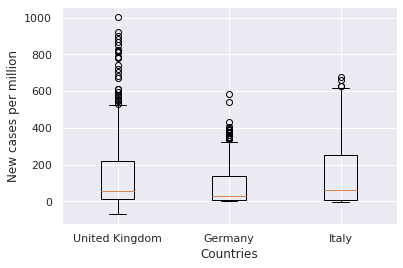

In [5]:
plt.boxplot([data[data['location']=='United Kingdom']['new_cases_per_million'], 
             data[data['location']=='Germany']['new_cases_per_million'], data[data['location']=='Italy']['new_cases_per_million']], labels=['United Kingdom','Germany','Italy'])
plt.xlabel('Countries')
plt.ylabel('New cases per million')
plt.savefig('newcases.png')
plt.show()

Total vaccination percentages of Turkey, United States, France and Japan. United States' vaccination percentage increased way more faster than the other 3 countries. Turkey and France seems to have vaccinated near amounts of their populations. Japan seems like they are slow at vaccinations.

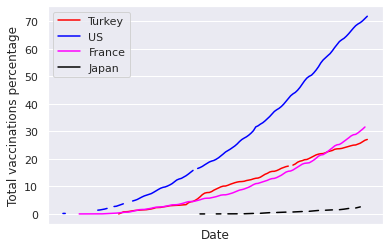

In [6]:
fig, ax = plt.subplots()
ax.plot(data[data['location']=='Turkey']['date'], data[data['location']=='Turkey']['total_vaccinations_per_hundred'], color='red')
ax.plot(data[data['location']=='United States']['date'], data[data['location']=='United States']['total_vaccinations_per_hundred'], color='blue')
ax.plot(data[data['location']=='France']['date'], data[data['location']=='France']['total_vaccinations_per_hundred'], color='magenta')
ax.plot(data[data['location']=='Japan']['date'], data[data['location']=='Japan']['total_vaccinations_per_hundred'], color='black')
plt.xlabel('Date')
ax.set_xticks([])
plt.ylabel('Total vaccinations percentage')
plt.legend(['Turkey','US','France','Japan'])
plt.savefig("total_vac.png")
plt.show()

Death count of the world due to coronavirus. Unfortunately, more than 3 milion people have died. The amount of deaths increased exponentially.

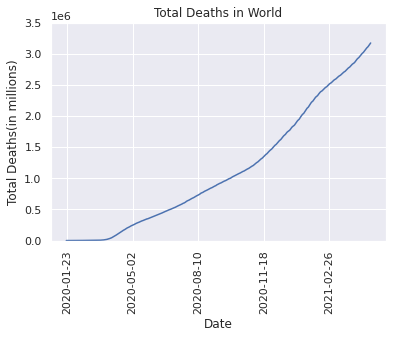

In [7]:
fig, ax = plt.subplots()
ax.plot(data[data['location']=='World']['date'], data[data['location']=='World']['total_deaths'])
ax.set_xticks([x for x in range(1,data[data['location']=='World']['date'].shape[0],100)])
plt.xticks(rotation=90)
plt.ylim((0, 3500000))
plt.xlabel('Date')
plt.ylabel('Total Deaths(in millions)')
plt.title('Total Deaths in World')
plt.savefig('world.png')
plt.show()

Looking at the total cases per million for 5 continents. Africa and Asia seems to have way less cases than Europe and American continents. The reason may be the emptyness of the information or people's request for a test. Also, Asia has more than half of the worlds population, which may lead to better results than the other continents, in the case of good protection.

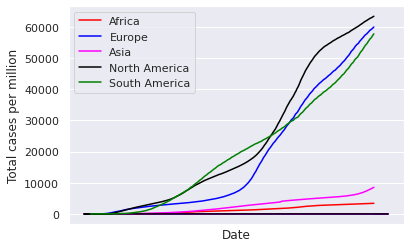

In [8]:
fig, ax = plt.subplots()
ax.plot(data[data['location']=='Africa']['date'], data[data['location']=='Africa']['total_cases_per_million'], color='red')
ax.plot(data[data['location']=='Europe']['date'], data[data['location']=='Europe']['total_cases_per_million'], color='blue')
ax.plot(data[data['location']=='Asia']['date'], data[data['location']=='Asia']['total_cases_per_million'], color='magenta')
ax.plot(data[data['location']=='North America']['date'], data[data['location']=='North America']['total_cases_per_million'], color='black')
ax.plot(data[data['location']=='South America']['date'], data[data['location']=='South America']['total_cases_per_million'], color='green')
plt.xlabel('Date')
ax.set_xticks([])
plt.ylabel('Total cases per million')
plt.legend(['Africa','Europe','Asia','North America','South America'])
plt.savefig("continents.png")
plt.show()

Dropping some features.


iso_code(3 letter codes of countries) is dropped because the location feature already provides the country name.

smoothed versions of cases,deaths,tests and vaccinations are dropped because they are closely correlated with normal versions.

weekly_icu_admission and weekly_hosp_admissions are dropped because the amount of data in these columnns are small.

aged_70_older is dropped because the aged_65_older feature is closely correlated with that.

In [9]:
data.drop(labels=['iso_code','new_deaths_smoothed','new_cases_smoothed','new_cases_smoothed_per_million',
                   'new_deaths_smoothed_per_million', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
                      'new_vaccinations_smoothed','new_vaccinations_smoothed_per_million', 'aged_70_older',
                  'weekly_icu_admissions','weekly_icu_admissions_per_million','weekly_hosp_admissions', 
                  'weekly_hosp_admissions_per_million'], axis=1,inplace=True)
data

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85166,Africa,Zimbabwe,2021-04-26,38102.0,16.0,1560.0,3.0,2563.560,1.077,104.959,0.202,1.01,NaN,NaN,NaN,NaN,1495.0,484446.0,32.594,0.101,0.020,49.6,tests performed,411610.0,353834.0,57776.0,21592.0,2.77,2.38,0.39,NaN,14862927.0,42.729,19.6,2.822,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
85167,Africa,Zimbabwe,2021-04-27,38164.0,62.0,1565.0,5.0,2567.731,4.171,105.296,0.336,1.01,NaN,NaN,NaN,NaN,2355.0,486801.0,32.753,0.158,0.024,41.2,tests performed,433939.0,370676.0,63263.0,22329.0,2.92,2.49,0.43,NaN,14862927.0,42.729,19.6,2.822,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
85168,Africa,Zimbabwe,2021-04-28,38191.0,27.0,1565.0,0.0,2569.548,1.817,105.296,0.000,1.00,NaN,NaN,NaN,NaN,2025.0,488826.0,32.889,0.136,0.018,56.9,tests performed,458013.0,388021.0,69992.0,24074.0,3.08,2.61,0.47,NaN,14862927.0,42.729,19.6,2.822,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
85169,Africa,Zimbabwe,2021-04-29,38235.0,44.0,1567.0,2.0,2572.508,2.960,105.430,0.135,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,477597.0,400771.0,76826.0,19584.0,3.21,2.70,0.52,NaN,14862927.0,42.729,19.6,2.822,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571


In the info(), it seems like there are null values even in continent column. When we look at this values, we see that this rows are from the whole continents and and the whole world. These are irrelevant for our goal.

In [10]:
data[data['continent'].isnull()==True]

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
432,NaN,Africa,2020-02-13,NaN,0.0,NaN,0.0,NaN,0.000,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.340598e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433,NaN,Africa,2020-02-14,1.0,1.0,NaN,0.0,0.001,0.001,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.340598e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
434,NaN,Africa,2020-02-15,1.0,0.0,NaN,0.0,0.001,0.000,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.340598e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
435,NaN,Africa,2020-02-16,1.0,0.0,NaN,0.0,0.001,0.000,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.340598e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
436,NaN,Africa,2020-02-17,1.0,0.0,NaN,0.0,0.001,0.000,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.340598e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83964,NaN,World,2021-04-26,147872402.0,682784.0,3120469.0,11156.0,18970.650,87.595,400.327,1.431,1.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.045371e+09,565137722.0,244623609.0,16393996.0,13.41,7.25,3.14,NaN,7.794799e+09,58.045,30.9,8.696,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,0.737
83965,NaN,World,2021-04-27,148716872.0,844470.0,3134956.0,14487.0,19078.988,108.338,402.186,1.859,1.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.065139e+09,572558181.0,250029440.0,19768227.0,13.66,7.35,3.21,NaN,7.794799e+09,58.045,30.9,8.696,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,0.737
83966,NaN,World,2021-04-28,149622864.0,905992.0,3150675.0,15719.0,19195.218,116.230,404.202,2.017,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.087697e+09,580920493.0,255747849.0,22557773.0,13.95,7.45,3.28,NaN,7.794799e+09,58.045,30.9,8.696,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,0.737
83967,NaN,World,2021-04-29,150520466.0,897602.0,3165665.0,14990.0,19310.372,115.154,406.125,1.923,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.112321e+09,589777392.0,263192812.0,24623727.0,14.27,7.57,3.38,NaN,7.794799e+09,58.045,30.9,8.696,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,0.737


Also there are null values in population column. When we look, we see that all of this examples are from Northern Cyprus. 

In [11]:
data.dropna(subset=['continent'],inplace=True)
data[data['population'].isnull()==True]

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
56949,Asia,Northern Cyprus,2021-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56950,Asia,Northern Cyprus,2021-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56951,Asia,Northern Cyprus,2021-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56952,Asia,Northern Cyprus,2021-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56953,Asia,Northern Cyprus,2021-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57044,Asia,Northern Cyprus,2021-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107365.0,58812.0,48553.0,NaN,28.09,15.39,12.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57045,Asia,Northern Cyprus,2021-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57046,Asia,Northern Cyprus,2021-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57047,Asia,Northern Cyprus,2021-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dropping the data from Northern Cyprus.

In [12]:
index_of_ncyprus =data[data['location'] == 'Northern Cyprus'].index
data.drop(index_of_ncyprus, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80960 entries, 0 to 85170
Data columns (total 45 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   continent                            80960 non-null  object 
 1   location                             80960 non-null  object 
 2   date                                 80960 non-null  object 
 3   total_cases                          78966 non-null  float64
 4   new_cases                            78959 non-null  float64
 5   total_deaths                         69469 non-null  float64
 6   new_deaths                           69468 non-null  float64
 7   total_cases_per_million              78966 non-null  float64
 8   new_cases_per_million                78959 non-null  float64
 9   total_deaths_per_million             69469 non-null  float64
 10  new_deaths_per_million               69468 non-null  float64
 11  reproduction_rate           

Since our goal is to predict people_fully_vaccinated_per_hundred, we need to see the date which this feature is filled for the first time.

When we look, we see that first data of people_fully_vaccinated_per_hundred is from Germany and it is at 27 December, 2020.

In [13]:
data[data['people_fully_vaccinated_per_hundred'].isnull()==False][['location','date']].sort_values('date',ascending=True)

,location,date
29871,Germany,2020-12-27
29872,Germany,2020-12-28
29873,Germany,2020-12-29
29874,Germany,2020-12-30
29875,Germany,2020-12-31
...,...,...
72963,Sri Lanka,2021-04-30
78906,Turkey,2021-04-30
35020,Iceland,2021-04-30
61409,Philippines,2021-04-30


But when we look at the date which the people_vaccinated and total_vaccinations datas are provided together for the first time, we see that day is 15 December, 2020.

Since "fully vaccinated" means someone who took 2 doses of vaccine, we can fill the data before 27 December, with the formula:

$$
people\_fully\_vaccinated=total\_vaccinations - people\_vaccinated
$$

In [14]:
data[(data['people_vaccinated'].isnull()==False) & (data['total_vaccinations'].isnull()==False)].sort_values('date',ascending=True)[['date','location','people_vaccinated','total_vaccinations']]

,date,location,people_vaccinated,total_vaccinations
63439,2020-12-15,Russia,28500.0,28500.0
38050,2020-12-19,Israel,61.0,61.0
81076,2020-12-20,United States,556208.0,556208.0
38051,2020-12-20,Israel,7436.0,7436.0
81077,2020-12-21,United States,614117.0,614117.0
...,...,...,...,...
67548,2021-04-30,Serbia,2026571.0,3514605.0
34591,2021-04-30,Hungary,4023137.0,5971865.0
6631,2021-04-30,Bahrain,693423.0,1235170.0
5788,2021-04-30,Azerbaijan,966132.0,1488218.0


Because we have information about vaccine since the 15th of December, we drop the data before that date.

Also since the dataset already has the population and per million/per thousand/per hundred versions of some features, we can drop the original features, such as total cases and new cases.

Now we have 27412 examples.

In [15]:
vaccine=data[data['date'] >= '2020-12-15']
vaccine.drop(['total_cases','new_cases','total_deaths','new_deaths','icu_patients','hosp_patients','new_tests',
                 'total_tests','tests_per_case'],axis=1, inplace=True)
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27412 entries, 295 to 85170
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   continent                            27412 non-null  object 
 1   location                             27412 non-null  object 
 2   date                                 27412 non-null  object 
 3   total_cases_per_million              25993 non-null  float64
 4   new_cases_per_million                25993 non-null  float64
 5   total_deaths_per_million             24494 non-null  float64
 6   new_deaths_per_million               24494 non-null  float64
 7   reproduction_rate                    24526 non-null  float64
 8   icu_patients_per_million             2940 non-null   float64
 9   hosp_patients_per_million            3636 non-null   float64
 10  total_tests_per_thousand             12489 non-null  float64
 11  new_tests_per_thousand    

By executing the rows below, it fills the empty people_fully_vaccinated rows, if the total_vaccinations and people_vaccinated values are provided. After that, it fills the per_hundred version of the people fully vaccinated using the population.

In [16]:
vaccine['people_fully_vaccinated'] = vaccine.apply(
    lambda row: row.total_vaccinations - row.people_vaccinated 
    if np.isnan(row.people_fully_vaccinated) else row.people_fully_vaccinated, axis=1)

In [17]:
vaccine['people_fully_vaccinated_per_hundred'] = vaccine.apply(
    lambda row: (row.people_fully_vaccinated / row.population)*100
    if np.isnan(row.people_fully_vaccinated_per_hundred) else row.people_fully_vaccinated_per_hundred, axis=1)

The count of non-null examples in people_fully_vaccinated_per_hundred column increased from 5577 to 7695.

In [18]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27412 entries, 295 to 85170
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   continent                            27412 non-null  object 
 1   location                             27412 non-null  object 
 2   date                                 27412 non-null  object 
 3   total_cases_per_million              25993 non-null  float64
 4   new_cases_per_million                25993 non-null  float64
 5   total_deaths_per_million             24494 non-null  float64
 6   new_deaths_per_million               24494 non-null  float64
 7   reproduction_rate                    24526 non-null  float64
 8   icu_patients_per_million             2940 non-null   float64
 9   hosp_patients_per_million            3636 non-null   float64
 10  total_tests_per_thousand             12489 non-null  float64
 11  new_tests_per_thousand    

It still has lots of null values, we can fill some of them with backfill method. But we need to separate the countries from each other to execute this operation correctly. By using backfill limit as 1, we don't fill consecutive null values, which may lead the model to give wrong results.

In [19]:
for country in vaccine['location'].unique():
    country_vaccine = vaccine[vaccine['location'] == country]
    country_vaccine.bfill(axis='rows',limit=1,inplace=True)
    vaccine[vaccine['location'] == country] = country_vaccine

We can also drop the vaccination features because we have their per hundred versions.

people_fully_vaccinated_per_hundred has 8966 non-null values now.

In [20]:
vaccine.drop(['total_vaccinations','people_vaccinated','people_fully_vaccinated'],axis=1,inplace=True)
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27412 entries, 295 to 85170
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   continent                            27412 non-null  object 
 1   location                             27412 non-null  object 
 2   date                                 27412 non-null  object 
 3   total_cases_per_million              25993 non-null  float64
 4   new_cases_per_million                25993 non-null  float64
 5   total_deaths_per_million             24503 non-null  float64
 6   new_deaths_per_million               24503 non-null  float64
 7   reproduction_rate                    24530 non-null  float64
 8   icu_patients_per_million             2979 non-null   float64
 9   hosp_patients_per_million            3704 non-null   float64
 10  total_tests_per_thousand             13185 non-null  float64
 11  new_tests_per_thousand    

Since we filled enough, we can drop the examples with null people_fully_vaccinated_per_hundred.

In [21]:
vaccine.dropna(axis=0,subset=['people_fully_vaccinated_per_hundred'],inplace=True)
vaccine

,continent,location,date,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,total_tests_per_thousand,new_tests_per_thousand,positive_rate,tests_units,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
363,Asia,Afghanistan,2021-02-21,1428.368,0.617,62.474,0.051,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,12.04,38928341.0,54.422,18.6,2.581,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
364,Asia,Afghanistan,2021-02-22,1428.702,0.334,62.499,0.026,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,12.04,38928341.0,54.422,18.6,2.581,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
369,Asia,Afghanistan,2021-02-27,1431.014,0.283,62.756,0.026,0.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.02,0.00,12.04,38928341.0,54.422,18.6,2.581,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
370,Asia,Afghanistan,2021-02-28,1431.194,0.180,62.756,0.000,0.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.02,0.00,12.04,38928341.0,54.422,18.6,2.581,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
385,Asia,Afghanistan,2021-03-15,1438.155,0.000,63.167,0.051,1.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14,0.14,0.00,12.04,38928341.0,54.422,18.6,2.581,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85166,Africa,Zimbabwe,2021-04-26,2563.560,1.077,104.959,0.202,1.01,NaN,NaN,32.594,0.101,0.020,tests performed,21592.0,2.77,2.38,0.39,NaN,14862927.0,42.729,19.6,2.822,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
85167,Africa,Zimbabwe,2021-04-27,2567.731,4.171,105.296,0.336,1.01,NaN,NaN,32.753,0.158,0.024,tests performed,22329.0,2.92,2.49,0.43,NaN,14862927.0,42.729,19.6,2.822,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
85168,Africa,Zimbabwe,2021-04-28,2569.548,1.817,105.296,0.000,1.00,NaN,NaN,32.889,0.136,0.018,tests performed,24074.0,3.08,2.61,0.47,NaN,14862927.0,42.729,19.6,2.822,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
85169,Africa,Zimbabwe,2021-04-29,2572.508,2.960,105.430,0.135,1.00,NaN,NaN,NaN,NaN,NaN,NaN,19584.0,3.21,2.70,0.52,NaN,14862927.0,42.729,19.6,2.822,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571


In [22]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8966 entries, 363 to 85170
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   continent                            8966 non-null   object 
 1   location                             8966 non-null   object 
 2   date                                 8966 non-null   object 
 3   total_cases_per_million              8363 non-null   float64
 4   new_cases_per_million                8363 non-null   float64
 5   total_deaths_per_million             8278 non-null   float64
 6   new_deaths_per_million               8278 non-null   float64
 7   reproduction_rate                    8271 non-null   float64
 8   icu_patients_per_million             2349 non-null   float64
 9   hosp_patients_per_million            2898 non-null   float64
 10  total_tests_per_thousand             6269 non-null   float64
 11  new_tests_per_thousand     

handwashing_facilities, hosp_patients_per_million ,icu_patients_per_million columns still have lots of null values. We need to fill +- 6000 rows to use them in model, which is why we dropping them. The others can be filled because they have more non-null values and require much less filling.

In [23]:
vaccine.drop(axis=1, labels=['handwashing_facilities','hosp_patients_per_million','icu_patients_per_million'],inplace=True)

The remaining null values filled with mean of the each column.

test_units is dropped because of its irrelevancy.

In [24]:
vaccine=vaccine.fillna(vaccine.mean())
vaccine.drop("tests_units",axis=1,inplace=True)
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8966 entries, 363 to 85170
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   continent                            8966 non-null   object 
 1   location                             8966 non-null   object 
 2   date                                 8966 non-null   object 
 3   total_cases_per_million              8966 non-null   float64
 4   new_cases_per_million                8966 non-null   float64
 5   total_deaths_per_million             8966 non-null   float64
 6   new_deaths_per_million               8966 non-null   float64
 7   reproduction_rate                    8966 non-null   float64
 8   total_tests_per_thousand             8966 non-null   float64
 9   new_tests_per_thousand               8966 non-null   float64
 10  positive_rate                        8966 non-null   float64
 11  new_vaccinations           

reseting indexes.

In [25]:
vaccine.reset_index(drop=True, inplace=True)
vaccine

,continent,location,date,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,total_tests_per_thousand,new_tests_per_thousand,positive_rate,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index
0,Asia,Afghanistan,2021-02-21,1428.368,0.617,62.474,0.051,0.78000,678.501932,4.951688,0.096123,109852.842196,0.00,0.00,0.00,12.040000,38928341.0,54.422,18.6,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83,0.511
1,Asia,Afghanistan,2021-02-22,1428.702,0.334,62.499,0.026,0.80000,678.501932,4.951688,0.096123,109852.842196,0.00,0.00,0.00,12.040000,38928341.0,54.422,18.6,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83,0.511
2,Asia,Afghanistan,2021-02-27,1431.014,0.283,62.756,0.026,0.87000,678.501932,4.951688,0.096123,109852.842196,0.02,0.02,0.00,12.040000,38928341.0,54.422,18.6,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83,0.511
3,Asia,Afghanistan,2021-02-28,1431.194,0.180,62.756,0.000,0.90000,678.501932,4.951688,0.096123,109852.842196,0.02,0.02,0.00,12.040000,38928341.0,54.422,18.6,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83,0.511
4,Asia,Afghanistan,2021-03-15,1438.155,0.000,63.167,0.051,1.09000,678.501932,4.951688,0.096123,109852.842196,0.14,0.14,0.00,12.040000,38928341.0,54.422,18.6,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83,0.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8961,Africa,Zimbabwe,2021-04-26,2563.560,1.077,104.959,0.202,1.01000,32.594000,0.101000,0.020000,21592.000000,2.77,2.38,0.39,64.158802,14862927.0,42.729,19.6,2.822,1899.775,21.4000,307.846,1.82,1.600000,30.70000,1.7,61.49,0.571
8962,Africa,Zimbabwe,2021-04-27,2567.731,4.171,105.296,0.336,1.01000,32.753000,0.158000,0.024000,22329.000000,2.92,2.49,0.43,64.158802,14862927.0,42.729,19.6,2.822,1899.775,21.4000,307.846,1.82,1.600000,30.70000,1.7,61.49,0.571
8963,Africa,Zimbabwe,2021-04-28,2569.548,1.817,105.296,0.000,1.00000,32.889000,0.136000,0.018000,24074.000000,3.08,2.61,0.47,64.158802,14862927.0,42.729,19.6,2.822,1899.775,21.4000,307.846,1.82,1.600000,30.70000,1.7,61.49,0.571
8964,Africa,Zimbabwe,2021-04-29,2572.508,2.960,105.430,0.135,1.00000,678.501932,4.951688,0.096123,19584.000000,3.21,2.70,0.52,64.158802,14862927.0,42.729,19.6,2.822,1899.775,21.4000,307.846,1.82,1.600000,30.70000,1.7,61.49,0.571


The heatmap of correlations shows that there are some features with very high correlation. To get rid of this dependency, I dropped; total_vaccinations_per_hundred, people_vaccinated_per_hundred , median_age ,human_development_index and total_deaths_per_million.

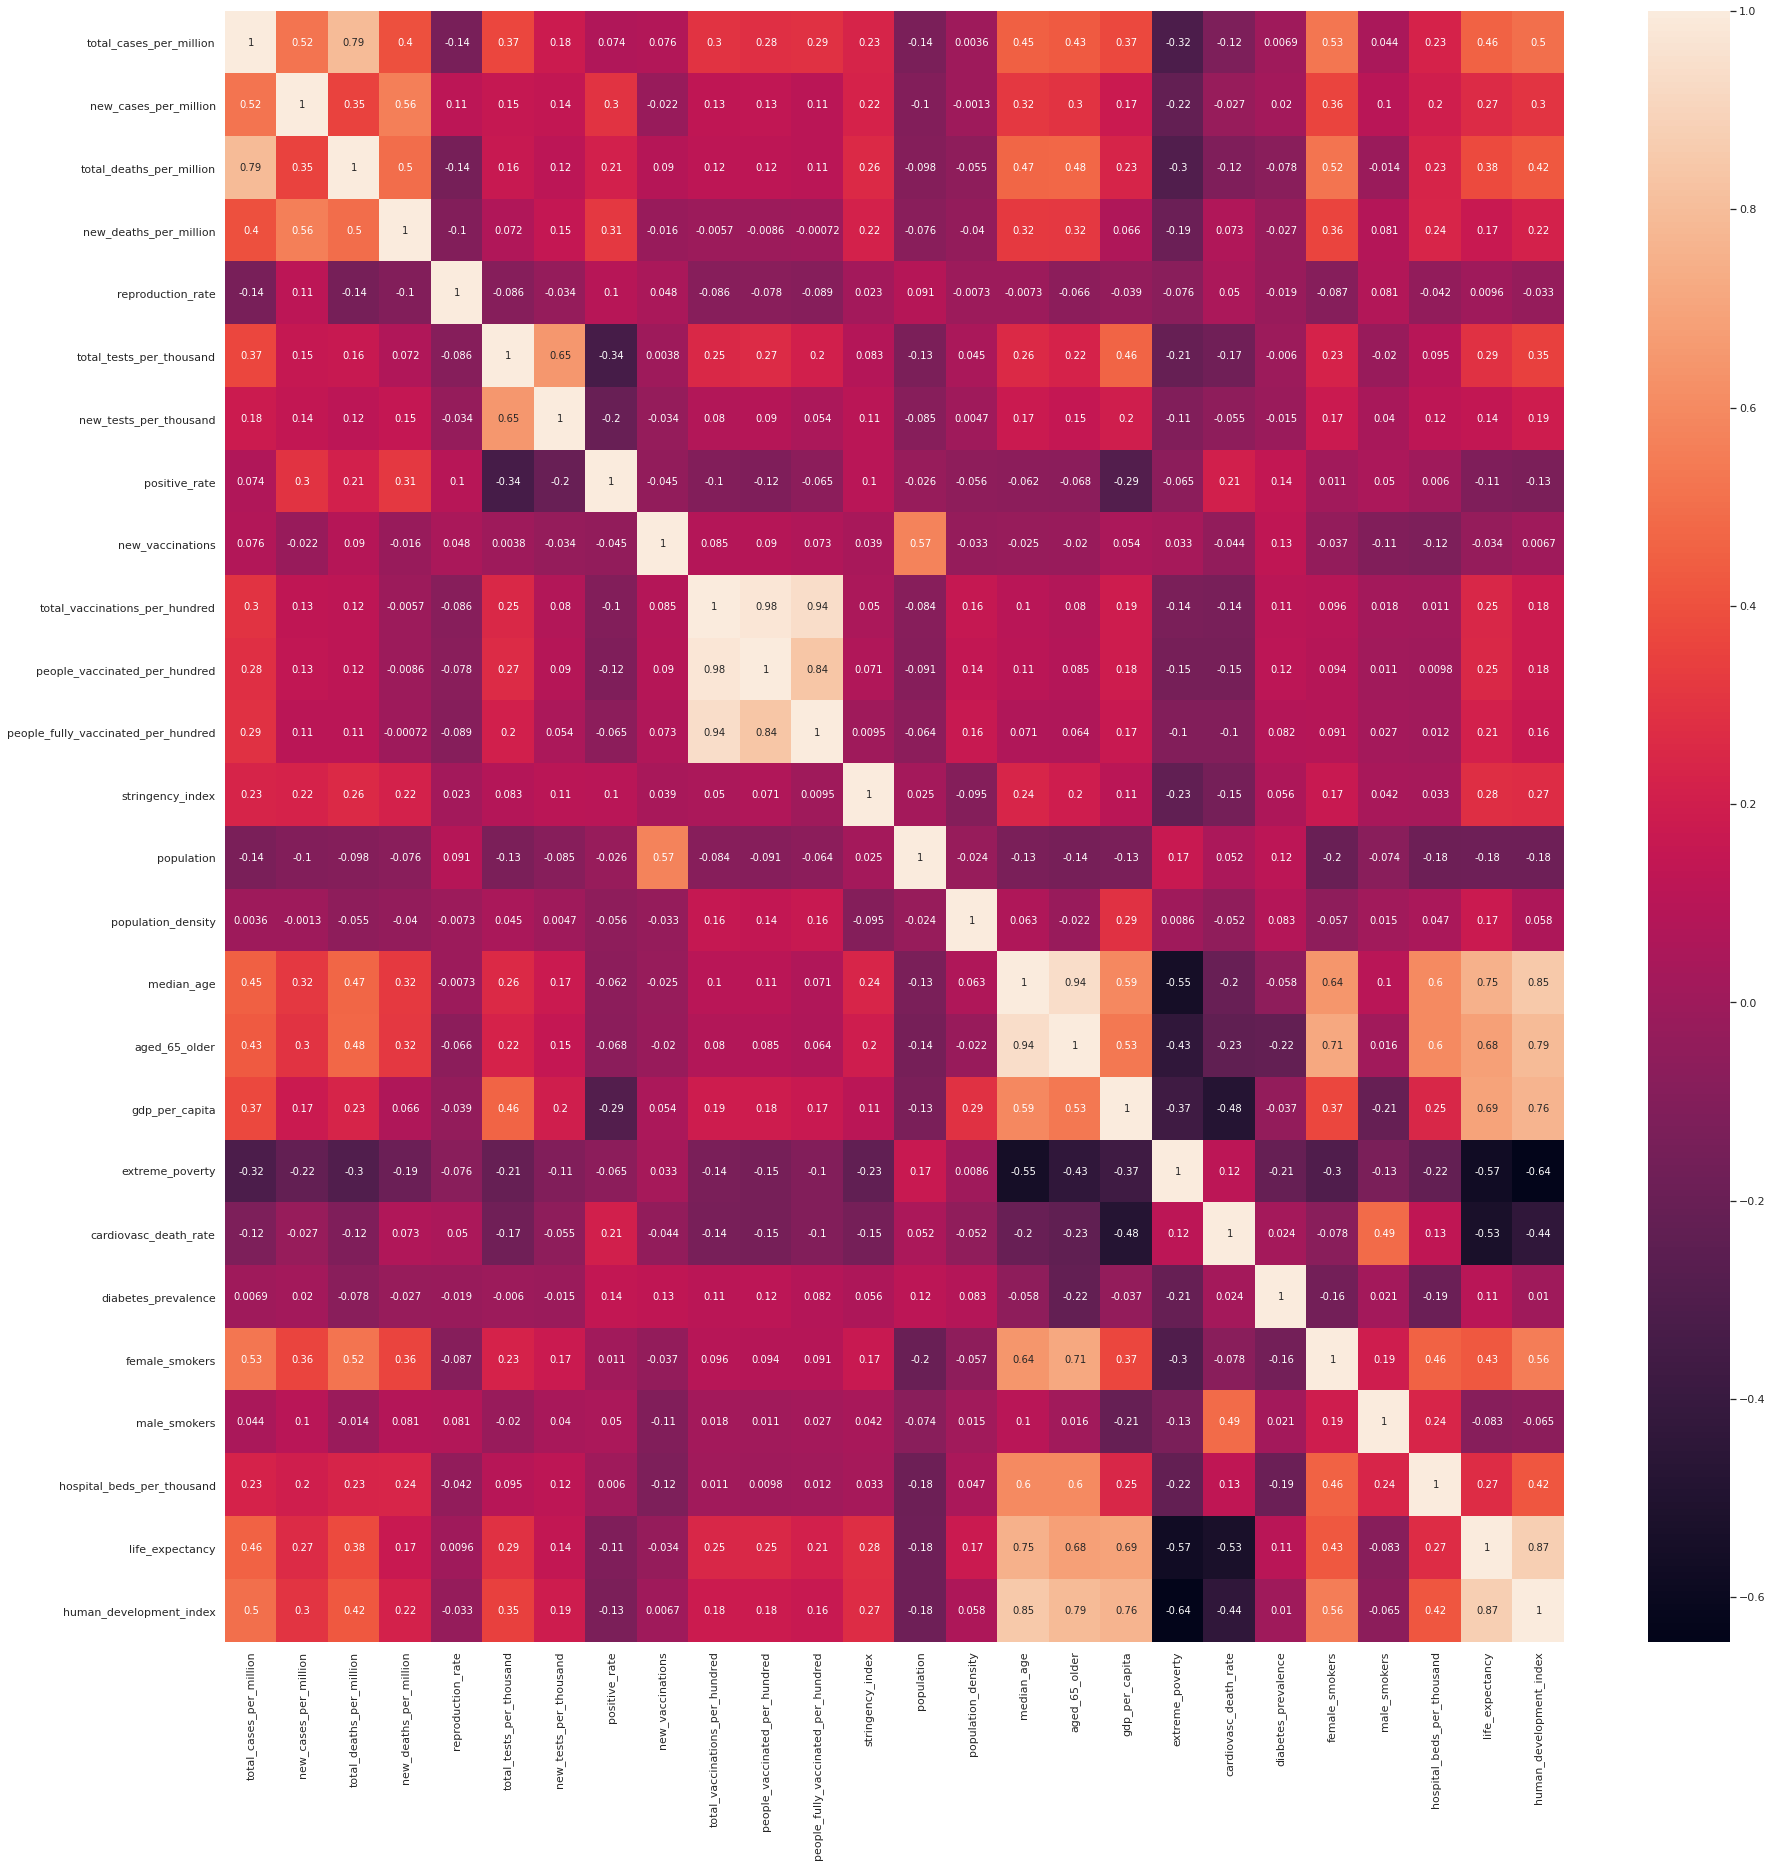

In [26]:
fig, ax=plt.subplots(figsize=(30,30))
sns.heatmap(vaccine.corr(), annot=True, ax=ax)
plt.show()

In [27]:
y = vaccine['people_fully_vaccinated_per_hundred']
X = vaccine.drop('people_fully_vaccinated_per_hundred',axis=1)
X.drop(["people_vaccinated_per_hundred",'median_age','human_development_index',
        'total_deaths_per_million',"total_vaccinations_per_hundred"],axis=1,inplace=True)
X

,continent,location,date,total_cases_per_million,new_cases_per_million,new_deaths_per_million,reproduction_rate,total_tests_per_thousand,new_tests_per_thousand,positive_rate,new_vaccinations,stringency_index,population,population_density,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy
0,Asia,Afghanistan,2021-02-21,1428.368,0.617,0.051,0.78000,678.501932,4.951688,0.096123,109852.842196,12.040000,38928341.0,54.422,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83
1,Asia,Afghanistan,2021-02-22,1428.702,0.334,0.026,0.80000,678.501932,4.951688,0.096123,109852.842196,12.040000,38928341.0,54.422,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83
2,Asia,Afghanistan,2021-02-27,1431.014,0.283,0.026,0.87000,678.501932,4.951688,0.096123,109852.842196,12.040000,38928341.0,54.422,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83
3,Asia,Afghanistan,2021-02-28,1431.194,0.180,0.000,0.90000,678.501932,4.951688,0.096123,109852.842196,12.040000,38928341.0,54.422,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83
4,Asia,Afghanistan,2021-03-15,1438.155,0.000,0.051,1.09000,678.501932,4.951688,0.096123,109852.842196,12.040000,38928341.0,54.422,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8961,Africa,Zimbabwe,2021-04-26,2563.560,1.077,0.202,1.01000,32.594000,0.101000,0.020000,21592.000000,64.158802,14862927.0,42.729,2.822,1899.775,21.4000,307.846,1.82,1.600000,30.70000,1.7,61.49
8962,Africa,Zimbabwe,2021-04-27,2567.731,4.171,0.336,1.01000,32.753000,0.158000,0.024000,22329.000000,64.158802,14862927.0,42.729,2.822,1899.775,21.4000,307.846,1.82,1.600000,30.70000,1.7,61.49
8963,Africa,Zimbabwe,2021-04-28,2569.548,1.817,0.000,1.00000,32.889000,0.136000,0.018000,24074.000000,64.158802,14862927.0,42.729,2.822,1899.775,21.4000,307.846,1.82,1.600000,30.70000,1.7,61.49
8964,Africa,Zimbabwe,2021-04-29,2572.508,2.960,0.135,1.00000,678.501932,4.951688,0.096123,19584.000000,64.158802,14862927.0,42.729,2.822,1899.775,21.4000,307.846,1.82,1.600000,30.70000,1.7,61.49


In order to feed categorical data to a machine learning model, we need to encode it. Continent, Location and Date columns are encoded. In order to match countries after the prediction, X is copied.

In [28]:
encoder = LabelEncoder()
X_transformed=X.copy()
X_transformed['continent'] = encoder.fit_transform(X_transformed['continent'])
X_transformed['date'] = encoder.fit_transform(X_transformed['date'])
X_transformed['location'] = encoder.fit_transform(X_transformed['location'])
X_transformed

,continent,location,date,total_cases_per_million,new_cases_per_million,new_deaths_per_million,reproduction_rate,total_tests_per_thousand,new_tests_per_thousand,positive_rate,new_vaccinations,stringency_index,population,population_density,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy
0,1,0,66,1428.368,0.617,0.051,0.78000,678.501932,4.951688,0.096123,109852.842196,12.040000,38928341.0,54.422,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83
1,1,0,67,1428.702,0.334,0.026,0.80000,678.501932,4.951688,0.096123,109852.842196,12.040000,38928341.0,54.422,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83
2,1,0,72,1431.014,0.283,0.026,0.87000,678.501932,4.951688,0.096123,109852.842196,12.040000,38928341.0,54.422,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83
3,1,0,73,1431.194,0.180,0.000,0.90000,678.501932,4.951688,0.096123,109852.842196,12.040000,38928341.0,54.422,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83
4,1,0,88,1438.155,0.000,0.051,1.09000,678.501932,4.951688,0.096123,109852.842196,12.040000,38928341.0,54.422,2.581,1803.987,5.2326,597.029,9.59,15.633991,32.75549,0.5,64.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8961,0,183,130,2563.560,1.077,0.202,1.01000,32.594000,0.101000,0.020000,21592.000000,64.158802,14862927.0,42.729,2.822,1899.775,21.4000,307.846,1.82,1.600000,30.70000,1.7,61.49
8962,0,183,131,2567.731,4.171,0.336,1.01000,32.753000,0.158000,0.024000,22329.000000,64.158802,14862927.0,42.729,2.822,1899.775,21.4000,307.846,1.82,1.600000,30.70000,1.7,61.49
8963,0,183,132,2569.548,1.817,0.000,1.00000,32.889000,0.136000,0.018000,24074.000000,64.158802,14862927.0,42.729,2.822,1899.775,21.4000,307.846,1.82,1.600000,30.70000,1.7,61.49
8964,0,183,133,2572.508,2.960,0.135,1.00000,678.501932,4.951688,0.096123,19584.000000,64.158802,14862927.0,42.729,2.822,1899.775,21.4000,307.846,1.82,1.600000,30.70000,1.7,61.49


Since the dataset is time-series, if we want to make a prediction at some day t, the data should be trained with the days before t, not with the data after it. In order to split the data efficently, we store the number of examples of each country with the encoded location. In the for loop, it checks that, if there are 5 or more examples from the country the current country. If the answer is true, it carries the last 20% of the data to the test set.

In [29]:
countries = dict(X_transformed['location'].value_counts())
X_test=pd.DataFrame(columns=X_transformed.columns)
y_test=pd.Series()
for k,v in countries.items():
    if v >= 5:
        add = X_transformed[X_transformed['location']==k].sort_values('date',ascending=True)[-(v//5):]
        X_transformed.drop(add.index,axis=0,inplace=True)
        X_test=X_test.append(add)
        y_test=y_test.append(y.loc[add.index])
        y.drop(add.index,axis=0,inplace=True)

Shapes of the sets after the split.

In [30]:
print(f' X shape: {X_transformed.shape}')
print(f' X_test shape: {X_test.shape}')
print(f' y shape: {y.shape}')
print(f' y_test shape: {y_test.shape}')

 X shape: (7251, 23)
 X_test shape: (1715, 23)
 y shape: (7251,)
 y_test shape: (1715,)


In [31]:
X_transformed.reset_index(drop=True, inplace=True)
y.reset_index(drop=True,inplace=True)

In order to do cross validation at time-series, we need to pass a predefined split. 

test_fold is a list that holds, which example will be in which split's validation. -1 means always using it for training set.

In [32]:
countries = dict(X_transformed['location'].value_counts())
test_fold=[-1]*X_transformed.shape[0]
print(len(test_fold))

7251


Using the same ratio, %80 training and %20 validation for countries with more than or equal to 5 examples, we can use 1378 examples in validation set. Since I want to use a 5-fold cross validation, 275-276 will be the number of examples in each fold.

In [33]:
j=0
for i in countries.values():
    if i>=5:
        j=j+(i//5)
print(j)
j//5

1378


275

m is for checking the number of examples in split, fold for checking the total number of splits.

In [34]:
fold=0
m=0
for k,v in countries.items():
    if v >= 5:
        if m<276:
            validate = X_transformed[X_transformed['location']==k].sort_values('date',ascending=True)[-(v//5):].index
            for i in validate:
                test_fold[i]=fold
            m+=len(validate)
        else:
            m=0
            fold+=1
cv=PredefinedSplit(test_fold)

Standardization of the features.

In [35]:
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X_transformed)
X_scaled_test=scaler.transform(X_test)

Initialization of Regression models that will be used. 

In [36]:
lr = LinearRegression()
nn = MLPRegressor(random_state=0)
dt = DecisionTreeRegressor(random_state=0)
rf = RandomForestRegressor(random_state=0)
xg = xgb.XGBRegressor(random_state=0, objective='reg:squarederror')

A function to automize tuning.

For Linear Regression, there are no parameters to tune. It is directly passed into *cross_val_score* with the predefined split of cv.

Other models are tuned with some parameters and *GridCVSearch*.

In [37]:
def tune(model):
    if model==lr:
        return cross_val_score(model, X_transformed, y, cv=cv).mean()
    if model==nn:
        parameters={
            'hidden_layer_sizes':[(30,),(50,)],
            'learning_rate_init': np.arange(0.01, 0.13, 0.02)
        }
    if model==dt:
        parameters={
            'max_depth': [5,10],
            'min_samples_split':[2,3,4,5]
        }
    if model==rf:
        parameters={
            'n_estimators': [100, 300, 500],
            'max_depth': [5,10],
            'min_samples_split':[2,3,4]  
        }
    if model==xg:
        parameters = {
            'n_estimators': [100, 300, 500, 700],
            'learning_rate': np.arange(0.1, 0.55, 0.2),
            'max_depth': [5,10]
        }
    gs = GridSearchCV(model, parameters, cv=cv, verbose=1, n_jobs=-1).fit(X_transformed, y)
    return pd.DataFrame(gs.cv_results_)

The cross validation score of Linear Regression is very bad.

In [38]:
print(f"Linear Regression score --> {tune(lr)}")

Linear Regression score --> 0.04740418912549453


Let's see what is returns for other examples.

In [39]:
df=tune(nn)
df

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   46.3s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,param_learning_rate_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.895059,0.556235,0.001390,0.000178,"(30,)",0.01,"{'hidden_layer_sizes': (30,), 'learning_rate_i...",0.897496,0.846131,0.774932,0.856722,0.771690,0.829394,0.048909,1
1,1.682114,0.365671,0.001293,0.000060,"(30,)",0.03,"{'hidden_layer_sizes': (30,), 'learning_rate_i...",0.902514,0.830273,0.653407,0.822338,0.733997,0.788506,0.086151,3
2,1.547315,0.156326,0.001321,0.000151,"(30,)",0.05,"{'hidden_layer_sizes': (30,), 'learning_rate_i...",0.902898,0.808612,0.615385,0.819991,0.644821,0.758341,0.110043,9
3,1.356418,0.195193,0.001274,0.000041,"(30,)",0.07,"{'hidden_layer_sizes': (30,), 'learning_rate_i...",0.893594,0.762333,0.688505,0.785566,0.753339,0.776667,0.066743,5
4,1.053483,0.181074,0.001198,0.000045,"(30,)",0.09,"{'hidden_layer_sizes': (30,), 'learning_rate_i...",0.872220,0.753487,0.602386,0.718139,0.595922,0.708431,0.102815,11
5,0.932999,0.166416,0.001294,0.000144,"(30,)",0.11,"{'hidden_layer_sizes': (30,), 'learning_rate_i...",0.857203,0.760303,0.518370,0.768504,0.060739,0.593024,0.288952,12
6,2.184273,0.383070,0.001269,0.000039,"(50,)",0.01,"{'hidden_layer_sizes': (50,), 'learning_rate_i...",0.900930,0.840610,0.797947,0.880826,0.622095,0.808482,0.099663,2
7,1.619449,0.407251,0.001299,0.000050,"(50,)",0.03,"{'hidden_layer_sizes': (50,), 'learning_rate_i...",0.876556,0.818488,0.746994,0.823212,0.668906,0.786831,0.071930,4
8,1.321576,0.270277,0.001242,0.000104,"(50,)",0.05,"{'hidden_layer_sizes': (50,), 'learning_rate_i...",0.894043,0.811973,0.713313,0.830152,0.595809,0.769058,0.104229,6
9,1.135019,0.206926,0.001288,0.000037,"(50,)",0.07,"{'hidden_layer_sizes': (50,), 'learning_rate_i...",0.884063,0.791186,0.741609,0.839825,0.564780,0.764293,0.110538,8


We can directly see the best estimator with it'S rank test score.

Way better than Linear Regression for this problem.

In [40]:
df[df['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,param_learning_rate_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.895059,0.556235,0.00139,0.000178,"(30,)",0.01,"{'hidden_layer_sizes': (30,), 'learning_rate_i...",0.897496,0.846131,0.774932,0.856722,0.77169,0.829394,0.048909,1


Creating a dataframe for best parameters of each model.



In [41]:
df = df[df['rank_test_score']==1][['params','mean_test_score','mean_fit_time']]
df['model']=str(nn)
df

,params,mean_test_score,mean_fit_time,model
0,"{'hidden_layer_sizes': (30,), 'learning_rate_i...",0.829394,2.895059,"MLPRegressor(activation='relu', alpha=0.0001, ..."


Calling the remaining models and storing their best model in the df. This takes at least 15 minutes to run on GoogleColab.

In [42]:
for i in [dt,rf,xg]:
    model = tune(i)
    best = model[model['rank_test_score']==1][['params','mean_test_score','mean_fit_time']]
    best['model']=str(i)
    df = df.append(best)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 10.2min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.6min finished


XGBRegressor is clearly the best model to use, followed by Neural Network and RandomForestRegression(works very slower than NeuralNetwork). 

In [43]:
linreg = pd.DataFrame(data=[[np.nan, tune(lr),np.nan, str(lr)]],columns=df.columns)
df = df.append(linreg)
df

,params,mean_test_score,mean_fit_time,model
0,"{'hidden_layer_sizes': (30,), 'learning_rate_i...",0.829394,2.895059,"MLPRegressor(activation='relu', alpha=0.0001, ..."
4,"{'max_depth': 10, 'min_samples_split': 2}",0.693566,0.094040,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
11,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.827313,29.009831,"RandomForestRegressor(bootstrap=True, ccp_alph..."
3,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.894918,8.942499,"XGBRegressor(base_score=0.5, booster='gbtree',..."
0,NaN,0.047404,NaN,"LinearRegression(copy_X=True, fit_intercept=Tr..."


Checking the best model's parameters.

In [44]:
df.loc[3,'params']

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}

Initializing the selected model.

In [45]:
model=xgb.XGBRegressor(max_depth=5,learning_rate=0.1, n_estimators=700, random_state=0, objective='reg:squarederror')

Fitting the model and predicting test set. $R^2$ of it is very good.

In [46]:
model.fit(X_transformed, y)
prediction = model.predict(X_scaled_test)
print(f"R2 score of the model ---> {r2_score(y_test, prediction)}")
print(f"Mean squared error of the model ---> {mean_squared_error(y_test, prediction)}")

R2 score of the model ---> 0.9225629753101191
Mean squared error of the model ---> 15.231172084139294


Comparing actual rates and the predictions.

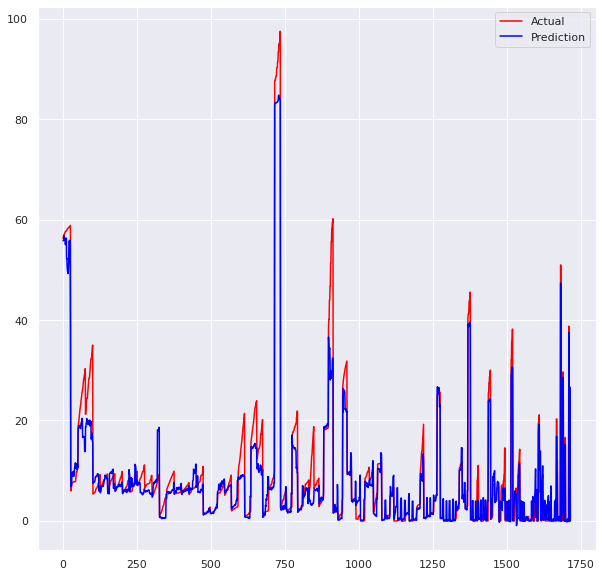

In [47]:
plt.figure(figsize=(10,10))
plt.plot(y_test.values, color='red')
plt.plot(prediction, color='blue')
plt.legend(['Actual','Prediction'])
plt.savefig("predictions.png")
plt.show()

Same lines as subgraphs.

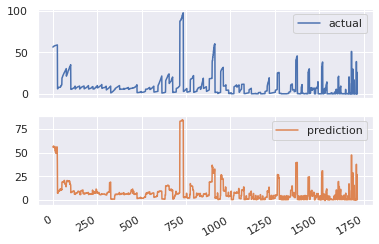

In [48]:
pd.DataFrame({'actual':y_test.values, 'prediction':prediction}).plot(subplots=True)
plt.show()

checking the worst prediction. idxmax gives the index of the maximum element.

In [49]:
mse = np.square(y_test-prediction)
print(f"maximum error-->{mse.max()}\nindex of it--->{mse.idxmax()}")

maximum error-->813.6695618818699
index of it--->7356


Looking at the features of the worst prediction.
It has the location code 147. 

In [50]:
X_test.loc[7356]

continent                            0
location                           147
date                               129
total_cases_per_million        53731.9
new_cases_per_million          793.167
new_deaths_per_million               0
reproduction_rate                 1.21
total_tests_per_thousand       678.502
new_tests_per_thousand         4.95169
positive_rate                 0.096123
new_vaccinations                109853
stringency_index                 43.52
population                       98340
population_density             208.354
aged_65_older                    8.606
gdp_per_capita                 26382.3
extreme_poverty                    1.1
cardiovasc_death_rate          242.648
diabetes_prevalence              10.55
female_smokers                     7.1
male_smokers                      35.7
hospital_beds_per_thousand         3.6
life_expectancy                   73.4
Name: 7356, dtype: object

By looking at the label encoder, we can access the country with code 147, it's Seychelles.

In [51]:
encoder.classes_[147]

'Seychelles'

It predicted only the half of the actual value.

In [52]:
worst=mse.argmax()
print(f'actual---> {y_test.iloc[worst]}\nprediction --->{prediction[worst]}')

actual---> 58.21
prediction --->29.68510627746582


I think because of the death values are empty and  some of the features(total tests, new tests, etc.) seems like filled with mean value, it got huge error when predicting this country. 

In [53]:
vaccine[(vaccine['location']=='Seychelles') & (vaccine['date']>='2021-02-01')][['location','date','total_cases_per_million','new_cases_per_million','new_deaths_per_million','total_tests_per_thousand','new_tests_per_thousand','people_fully_vaccinated_per_hundred']]

,location,date,total_cases_per_million,new_cases_per_million,new_deaths_per_million,total_tests_per_thousand,new_tests_per_thousand,people_fully_vaccinated_per_hundred
7299,Seychelles,2021-02-01,12436.445,183.038,10.169,678.501932,4.951688,0.00
7300,Seychelles,2021-02-02,12639.821,203.376,0.000,678.501932,4.951688,0.00
7301,Seychelles,2021-02-03,13005.898,366.077,0.000,678.501932,4.951688,0.01
7302,Seychelles,2021-02-05,13107.586,0.000,0.000,678.501932,4.951688,1.61
7303,Seychelles,2021-02-06,15293.878,2186.292,10.169,678.501932,4.951688,1.61
...,...,...,...,...,...,...,...,...
7356,Seychelles,2021-04-25,53731.950,793.167,0.000,678.501932,4.951688,58.21
7357,Seychelles,2021-04-26,54443.767,711.816,0.000,678.501932,4.951688,58.21
7358,Seychelles,2021-04-27,54443.767,0.000,0.000,678.501932,4.951688,59.48
7359,Seychelles,2021-04-28,55480.984,1037.218,0.000,678.501932,4.951688,59.48


Checking Turkey.

Prediction for Turkey seems perfect when rounded to 2 decimals.

In [54]:
turkey = pd.DataFrame(columns=['date','actual','prediction'])
turkey[['date','actual']] = vaccine[vaccine['location']=='Turkey'].sort_values('date',ascending=True)[['date','people_fully_vaccinated_per_hundred']]
for i in turkey.index.values[-15:]:
  turkey.loc[i,'prediction']=y_test[i]
turkey

,date,actual,prediction
8291,2021-02-11,0.40,NaN
8292,2021-02-12,0.40,NaN
8293,2021-02-13,0.54,NaN
8294,2021-02-14,0.58,NaN
8295,2021-02-15,0.68,NaN
...,...,...,...
8365,2021-04-26,9.61,9.61
8366,2021-04-27,9.84,9.84
8367,2021-04-28,10.22,10.22
8368,2021-04-29,10.58,10.58


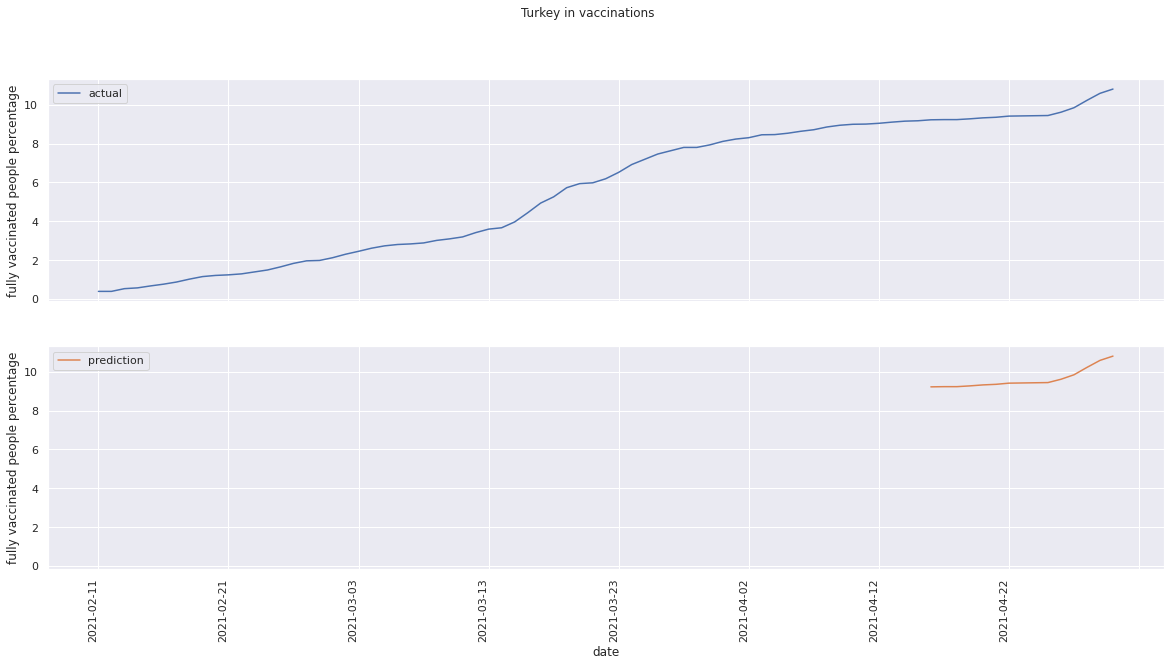

In [55]:
turkey.plot(x='date',y=['actual','prediction'], figsize=(20,10),
            ylabel='fully vaccinated people percentage',rot=90, title="Turkey in vaccinations",subplots=True,sharex=True,sharey=True)
plt.show()